# Error propagation in the pendulum
The purpose of this tutorial notebook is to demonstrate analytic error propagation with the pendulum. We need a prediction of the expected uncertainty to compare to the uncertainty output by the various methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# deepbench unfortunately still has to be installed with pip:
# 
import deepbench
from deepbench.physics_object import Pendulum

## Instantiate a pendulum object with noise
Here the noise will be on the theta parameter. Let's explore how deepbench creates noise as a function of time.

In [2]:
true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
# here, we will introduce a 10% error on the theta parameter
# and no error on any other parameters
percent_error = 0.5

# generate a pendulum object from deepbench
pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": 0.0,
                "starting_angle_radians": percent_error,
                "acceleration_due_to_gravity": 0.0,
            },
        )
# so in deepbench, noise is created by modifying the parameter value,
# using a random normal centered at the previous parameter value
# and a standard deviation which is scaled by this value multiplied by 
# the noise_level, which is effectively a true value standard deviation
# so percent_error = 0.5 should create noise on theta_0 that is
# 50% of the value at each moment in time

Now demonstrate the noise generation for a a series of moments in time. If you run this cell multiple times it will include different noisy draws.

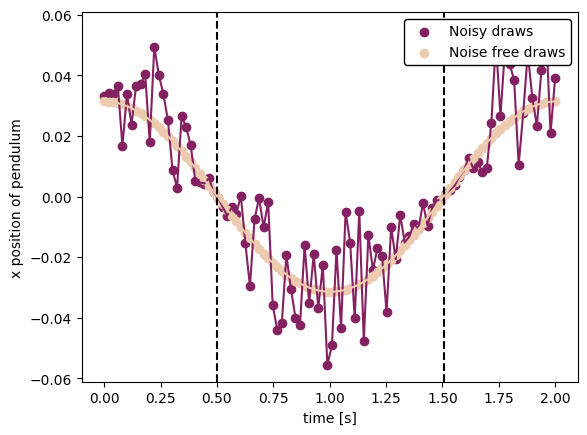

In [8]:
time = np.linspace(0,2,100)

# generate a noisy and a noiseless instance
pendulum_noisy = pendulum.create_object(time, noiseless=False)
pendulum_noiseless = pendulum.create_object(time, noiseless=True)


plt.clf()
plt.plot(time, pendulum_noisy, color = '#832161')
plt.scatter(time, pendulum_noisy, label = 'Noisy draws', color = '#832161')
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

Okay but this is one random iteration, let's plot some 1 sigma confidence intervals when we iterate many times to create noisy pendulums.

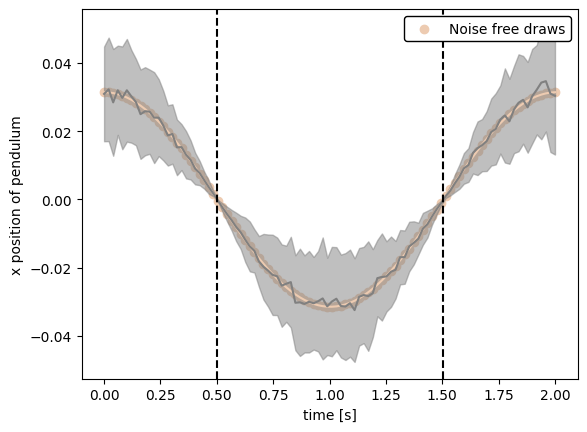

In [20]:
pendulum_noisy_list = np.zeros((len(time),100))
for r in range(100):
    pendulum_noisy_list[:,r] = pendulum.create_object(time, noiseless=False)
pendulum_noiseless = pendulum.create_object(time, noiseless=True)

# now take the mean and standard deviation
mean_trajectory = np.mean(pendulum_noisy_list, axis = 1)
std_trajectory = np.std(pendulum_noisy_list, axis = 1)

plt.clf()
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.fill_between(time, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5)
plt.plot(time, mean_trajectory, color = 'grey')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.axvline(x = (np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')
plt.axvline(x = (3 * np.pi/2)/np.sqrt(true_a/true_L), color = 'black', ls = '--')

plt.show()

You might notice that the noisy is time-variable on a periodic function with minimas at mutiples of pi/2. In order to best understand this and avoid a time dependence for the noise, let's understand this for only one moment in time.

https://www.youtube.com/watch?v=7L9EMe-7Z4w&ab_channel=MinhaCole%C3%A7%C3%A3oDeDVDs

Let's generate a bunch of noisy iterations of this pendulum object at one time (t = 0.75) and prove that these align with our expectation from the noisy pendulum simulator.

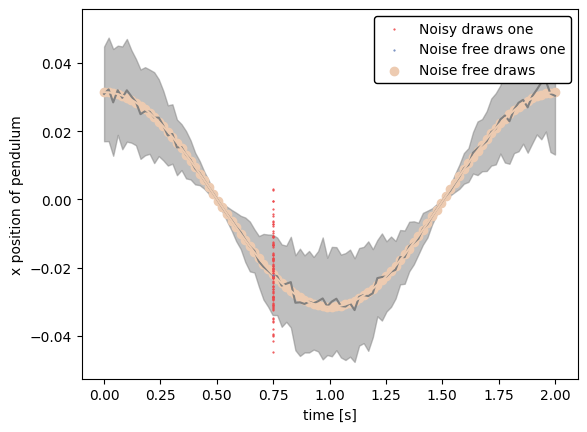

In [21]:
one_time = 0.75

plt.clf()
for i in range(100):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    if i == 0:
        plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one',
                    color = '#ED474A', zorder = 100, s = 0.3)
    else:
        plt.scatter(one_time, pendulum_noisy_one, color = '#ED474A', zorder = 100,
                    s = 0.3)
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA', zorder = 100, s = 0.3)
plt.fill_between(time, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5)
plt.plot(time, mean_trajectory, color = 'grey')
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

Okay so the spread of the red draws from pendulum for one moment in time seem to line up with our expectation for the jitter at that moment in time. But how does do we actually expect this error to propagate?

For a review of error propagation, see the 'Simple Uncertainty Propagation' section of https://docs.google.com/document/d/1uAt3-yi-eH14hs95wGvF3qokyWpINpkoKDYHVglkeO0/edit?usp=sharing.

To summarize briefly here, error propagation can be predicted using partial derivatives relative to the parameters. 

Here:

$$x = f(L,\theta_0,a_g)$$

$$dx = \frac{\partial f}{\partial L} dL + \frac{\partial f}{\partial \theta_0} d \theta_0 + \frac{\partial f}{\partial a_g} da_g$$

where $dx$ is the absolute error on x, $dL$, $d\theta_0$, and $da_g$ are the absolute errors on the parameters, which is the percent error multiplied by the parameter value.

In our case, if $dL = da_g = 0$, we only need to deal with the partial with respect to $\theta_0$:

$$x = L \ sin(\theta_0 \ cos (\sqrt{\frac{a_g}{L}} t))$$

$$dx = \frac{\partial f}{\partial \theta_0} d \theta_0  = L \ cos(\theta_0\ cos(\sqrt{\frac{a_g}{L}}\ t)) \ cos(\sqrt{\frac{a_g}{L}} \ t) d\theta_0$$

Okay, but that's just relative to $\theta_0$. You can see that there are two cosine functions that zero out at multiples of $(\pi / 2) * \sqrt{\frac{a_g}{L}}$. 

Let's rerun this analysis with error relative to L and $a_g$. First, L.

$$dx = \frac{\partial f}{\partial L} d L  = (\ sin(\theta_0 \ cos (\sqrt{\frac{a_g}{L}} t)) + \frac{1}{2} \ \theta_0 \ t \ \sqrt{\frac{a_g}{L^2}} \ sin(t\ \sqrt{\frac{a_g}{L}}) \ cos(\theta_0 \ cos(t \ \sqrt{\frac{a_g}{L}})))  * dL$$

Now relative to $a_g$ only.

$$dx = \frac{\partial f}{\partial a_g} d a_g  = (-\frac{1}{2}\sqrt{\frac{L}{a_g}} \theta_0 \ t \ sin(\sqrt{\frac{a_g}{L}}\ t) \ cos(\theta_0\ cos(\sqrt{\frac{a_g}{L}}t)))   * da_g$$

Below is the more general error propagation formula that combines all of these three relative formulae. It also includes an option for wrt == 'all' (with respect to), where dthing is now a list with [dL, dtheta, da].

In [23]:
# how should the error propagate? 
# its all partial derivatives
def calc_error_prop(true_L, true_theta, true_a, dthing, time, wrt = 'theta_0'):
    if wrt == 'theta_0':
        dx_dthing = true_L * np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time)) * \
              np.cos(np.sqrt(true_a / true_L) * time) * dthing
    if wrt == 'L':
        dx_dthing = (0.5 * true_theta * time * np.sqrt(true_a / true_L**2) * np.sin(time * np.sqrt(true_a / true_L)) * \
             np.cos(true_theta * np.cos(time * np.sqrt(true_a / true_L))) + \
             np.sin(true_theta * np.cos(time * np.sqrt(true_a / true_L)))) * dthing
    if wrt == 'a_g':
        dx_dthing = (- 0.5 * np.sqrt(true_L / true_a) * true_theta * time * \
            np.sin(np.sqrt(true_a / true_L) * time) * \
            np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time))) * dthing
    if wrt == 'all':
        dx_dthing = true_L * np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time)) * \
              np.cos(np.sqrt(true_a / true_L) * time) * dthing[1] + \
                    (0.5 * true_theta * time * np.sqrt(true_a / true_L**2) * np.sin(time * np.sqrt(true_a / true_L)) * \
             np.cos(true_theta * np.cos(time * np.sqrt(true_a / true_L))) + \
             np.sin(true_theta * np.cos(time * np.sqrt(true_a / true_L)))) * dthing[0] + \
                    (- 0.5 * np.sqrt(true_L / true_a) * true_theta * time * \
            np.sin(np.sqrt(true_a / true_L) * time) * \
            np.cos(true_theta * np.cos(np.sqrt(true_a / true_L) * time))) * dthing[2]
    return dx_dthing


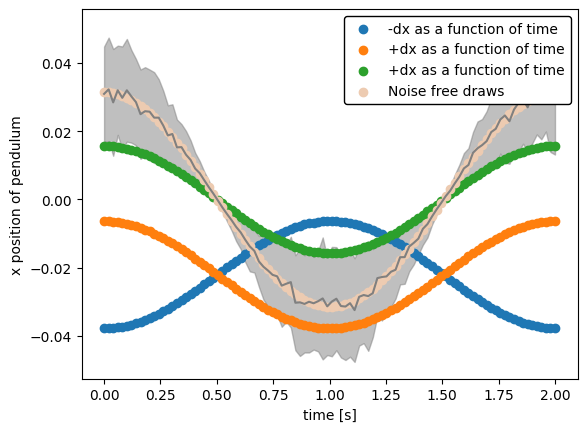

In [29]:
plt.clf()
plt.fill_between(time, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory,
                 color = 'grey', alpha = 0.5)
plt.plot(time, mean_trajectory, color = 'grey')

plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')

# okay but also compare to our expectation for noise value

dx = calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = one_time, wrt = 'theta_0')



# try to do this for multiple times
dx_list = []
for t in time:
    dx_list.append(calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = t, wrt = 'theta_0'))

plt.scatter(time, pendulum_noiseless_one - dx_list, label = '-dx as a function of time')
plt.scatter(time, pendulum_noiseless_one + dx_list, label = '+dx as a function of time')
plt.scatter(time, dx_list, label = '+dx as a function of time')

plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')

legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)


plt.show()


Okay so now compare 1000 draws from the x position of the noisy pendulum to the 1000 draws from the expected dx from the analytic error propagation multiplied by a draw from a standard normal.

$\theta_0$ =  0.031415926535897934 % error =  0.5 absolute error =  0.015707963267948967
x =  -0.023558314375243878 dx =  -0.011011704799075265


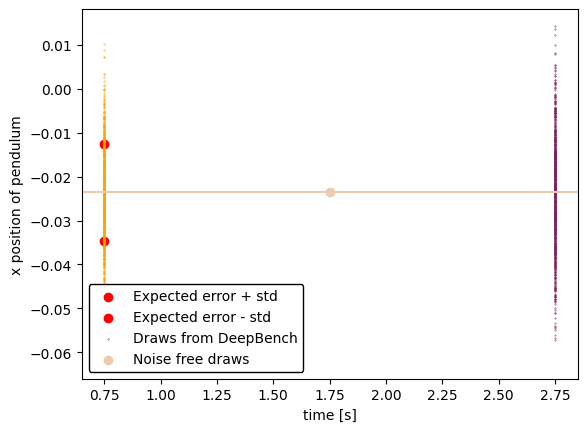

one time 0.75


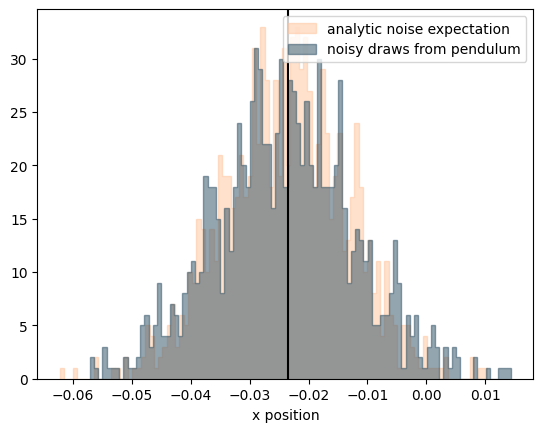

In [82]:
dx_dtheta_0 = calc_error_prop(true_L, true_theta, true_a,
                              percent_error * true_theta,
                              time = one_time, wrt = 'theta_0')

print(r'$\theta_0$ = ', true_theta, r'% error = ', percent_error, 'absolute error = ', percent_error * true_theta)
print('x = ', pendulum_noiseless_one, 'dx = ', dx_dtheta_0)

plt.clf()

#plt.plot(time, pendulum_noisy, color = '#832161')

#plt.plot(time,  dx   , color = 'red', label = 'Expected error')
plt.scatter(one_time, dx_dtheta_0 + pendulum_noiseless_one, color = 'red',
            label = 'Expected error + std')
plt.scatter(one_time, -dx_dtheta_0 + pendulum_noiseless_one, color = 'red',
            label = 'Expected error - std')

# first plot the predicted scatter
analytic_noise = []
for r in range(1000):
    rs = np.random.RandomState()#2147483648)# 
    attribute = rs.normal(loc=0, scale=1)
    '''
    print('random number', attribute)
    print('dx_dtheta_0', dx_dtheta_0)
    print('pendulum_noiseless_one', pendulum_noiseless_one)
    print('the noise we are adding to this', attribute * dx_dtheta_0)
    STOP
    '''
    plt.scatter(one_time, attribute * dx_dtheta_0 + pendulum_noiseless_one, color = 'orange', s= 0.1)#, label = 'Expected error plus gaussian random noise')
    analytic_noise.append(attribute * dx_dtheta_0 + pendulum_noiseless_one)
# then also doing 100 draws from the pendulum
noisy_pendulum = []
for r in range(1000):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    noisy_pendulum.append(pendulum_noisy_one)
    if r == 0:
        plt.scatter(one_time+2, pendulum_noisy_one,
                    color = '#832161', s = 0.1, label = 'Draws from DeepBench')
    else:
        plt.scatter(one_time+2, pendulum_noisy_one,
                    color = '#832161', s = 0.1)#label = 'Noisy draws', 
plt.scatter(one_time+1, pendulum_noiseless_one,
            label = 'Noise free draws', color = '#EDCBB1')
plt.axhline(y = pendulum_noiseless_one, color = '#EDCBB1')
legend = plt.legend(loc="lower left", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

print('one time', one_time)

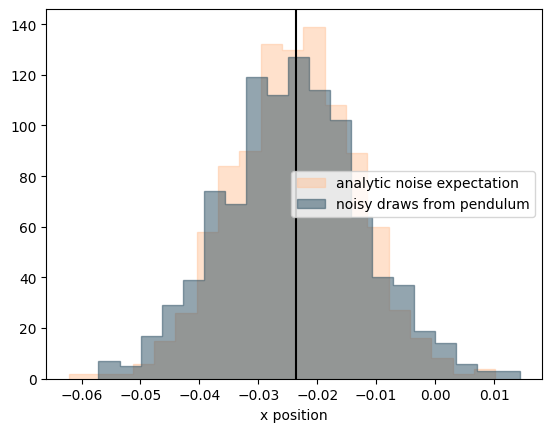

In [83]:
bins = 20
plt.clf()
plt.hist(analytic_noise,
         bins = bins, color = '#FFC49B', alpha = 0.5,
         label = 'analytic noise expectation',
         histtype='step', fill = True)
plt.hist(noisy_pendulum,
         bins = bins, color = '#294C60', alpha = 0.5,
         label = 'noisy draws from pendulum',
         histtype='step', fill = True)
plt.legend()
plt.xlabel('x position')
plt.axvline(x = pendulum_noiseless_one, color = 'black')
plt.show()

Is the noisy draws from the pendulum asymmetric? It certainly seems so here. I'll need to do some troubleshooting.